<a href="https://colab.research.google.com/github/rahiakela/machine-learning-research-and-practice/blob/main/hands-on-machine-learning-with-scikit-learn-keras-and-tensorflow/11-training-deep-neural-networks/04_handling_overfitting_through_regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Handling Overfitting Through Regularization

With thousands of parameters you can fit the whole zoo. Deep neural networks typically have tens of thousands of parameters, sometimes even millions. With so many parameters, the network has an incredible amount of freedom and can fit a huge variety of complex datasets. But this great flexibility also means that it is prone to overfitting the training set. We need regularization.

In this section we will present other popular regularization techniques for neural networks:
* ℓ1 and ℓ2 regularization, 
* dropout and 
* max-norm regularization.

## Setup

In [5]:
import sys
import sklearn 

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras

# Common imports
import numpy as np
from functools import partial
import os

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD
import tensorflow.keras.backend as keras_backend

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.
X_test = X_test / 255.

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

# Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [3]:
def plot_accuracy_and_loss(history, plot_title):
    xs = range(len(history.history['accuracy']))

    plt.figure(figsize=(10,3))
    plt.subplot(1, 2, 1)
    plt.plot(xs, history.history['accuracy'], label='train')
    plt.plot(xs, history.history['val_accuracy'], label='test')
    plt.legend(loc='lower left')
    plt.xlabel('epochs')
    plt.ylabel('accuracy')
    plt.title(plot_title+', Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(xs, history.history['loss'], label='train')
    plt.plot(xs, history.history['val_loss'], label='test')
    plt.legend(loc='upper left')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.title(plot_title+', Loss')

    #plt.tight_layout()
    plt.show()

## ℓ1 and ℓ2 Regularization

You can use $L_1$ and $L_2$ regularization to constrain a neural network’s connection weights (but typically not its biases) and/or $L_1$ regularization if you want a sparse model.

Here is how to apply $L_2$ regularization to a Keras layer’s connection weights,
using a regularization factor of 0.01:

```python
layer = keras.layers.Dense(100, activation="elu",
                              kernel_initializer="he_normal",
                              kernel_regularizer=keras.regularizers.l2(0.01))
```

The `l2()` function returns a regularizer that will be called to compute the regularization
loss, at each step during training. This regularization loss is then added to the
final loss.

As you might expect, you can just use `keras.regularizers.l1()` if you want $L_1$ regularization, and if you want both $L_1$ and $L_2$ regularization, use `keras.regularizers.l1_l2()` (specifying both regularization factors).

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    Dense(300, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)),
    Dense(100, activation='selu', kernel_initializer='lecun_normal', kernel_regularizer=keras.regularizers.l2(0.01)), 
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

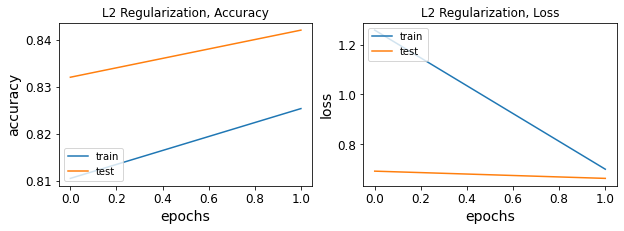

In [6]:
plot_accuracy_and_loss(history, 'L2 Regularization')

Since you will typically want to apply the same regularizer to all layers in your network,
as well as the same activation function and the same initialization strategy in all
hidden layers, you may find yourself repeating the same arguments over and over.
This makes it ugly and error-prone. 

To avoid this, you can try refactoring your code
to use loops. Another option is to use Python’s `functools.partial()` function: it lets
you create a thin wrapper for any callable, with some default argument values.

In [ ]:
RegularizedDense = partial(Dense, activation='elu', kernel_initializer='he_normal', kernel_regularizer=keras.regularizers.l2(0.01))

model = Sequential([
    Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100), 
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

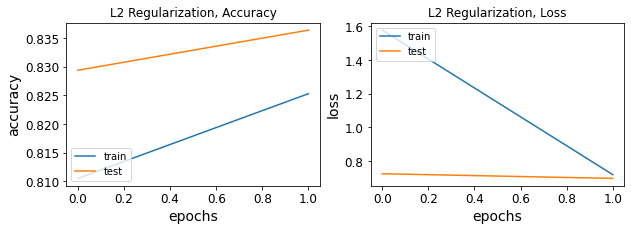

In [8]:
plot_accuracy_and_loss(history, 'L2 Regularization')

## Dropout

Dropout is one of the most popular regularization techniques for deep neural networks and it has proven to be highly successful: even the state-ofthe-art neural networks got a 1–2% accuracy boost simply by adding dropout. 

This may not sound like a lot, but when a model already has 95% accuracy, getting a 2% accuracy boost means dropping the error rate by almost 40% (going from 5% error to roughly 3%).

It is a fairly simple algorithm: at every training step, every neuron (including the input neurons, but always excluding the output neurons) has a probability $p$ of being temporarily “dropped out,” meaning it will be entirely ignored during this training step, but it may be active during the next step The hyperparameter $p$ is called the dropout rate, and it is typically set to 50%. After training, neurons don’t get dropped anymore. And that’s all.

<img src='https://github.com/rahiakela/img-repo/blob/master/hands-on-machine-learning-keras-tensorflow/dropout-regularization.PNG?raw=1' width='400'/>

To implement dropout using Keras, you can use the keras.layers.Dropout layer.
During training, it randomly drops some inputs (setting them to 0) and divides the
remaining inputs by the keep probability. After training, it does nothing at all, it just
passes the inputs to the next layer.

In [9]:
keras_backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    Dense(300, activation='elu', kernel_initializer='lecun_normal'),
    keras.layers.Dropout(rate=0.2),
    Dense(100, activation='elu', kernel_initializer='lecun_normal'), 
    keras.layers.Dropout(rate=0.2),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

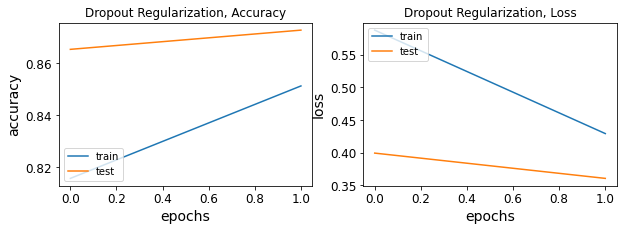

In [11]:
plot_accuracy_and_loss(history, 'Dropout Regularization')

## Alpha Dropout

In [12]:
keras_backend.clear_session()

tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
model = Sequential([
    Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    Dense(300, activation='selu', kernel_initializer='lecun_normal'),
    keras.layers.AlphaDropout(rate=0.2),
    Dense(100, activation='selu', kernel_initializer='lecun_normal'), 
    keras.layers.AlphaDropout(rate=0.2),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

optimizer = keras.optimizers.SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

In [15]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.5388 - accuracy: 0.8579


[0.5387945771217346, 0.8579000234603882]

In [16]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4232 - accuracy: 0.8794


[0.42316412925720215, 0.8794000148773193]

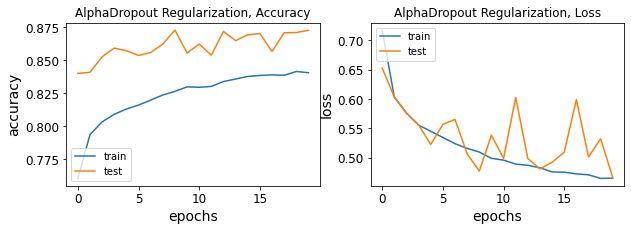

In [14]:
plot_accuracy_and_loss(history, 'AlphaDropout Regularization')

If you observe that the model is overfitting, you can increase the dropout rate. Conversely,
you should try decreasing the dropout rate if the model underfits the training
set. It can also help to increase the dropout rate for large layers, and reduce it for
small ones. 

Moreover, many state-of-the-art architectures only use dropout after the
last hidden layer, so you may want to try this if full dropout is too strong.

Dropout does tend to significantly slow down convergence, but it usually results in a
much better model when tuned properly. 

So, it is generally well worth the extra time
and effort.

##Monte Carlo (MC) Dropout

## Max-Norm Regularization

Another regularization technique that is quite popular for neural networks is called
max-norm regularization: for each neuron, it constrains the weights w of the incoming
connections such that ∥ *w* ∥2 ≤ _r_, where r is the max-norm hyperparameter
and ∥ · ∥2 is the ℓ2 norm.

Max-norm regularization does not add a regularization loss term to the overall loss
function. Instead, it is typically implemented by computing ∥w∥2 after each training
step and clipping w if needed.

Reducing r increases the amount of regularization and helps reduce overfitting. Maxnorm
regularization can also help alleviate the vanishing/exploding gradients problems
(if you are not using Batch Normalization).

To implement max-norm regularization in Keras, just set every hidden layer’s ker
nel_constraint argument to a max_norm() constraint, with the appropriate max
value.

```python
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal",
                    kernel_constraint=keras.constraints.max_norm(1.))
```

In [ ]:
MaxNormDense = partial(keras.layers.Dense, activation='selu', kernel_initializer='lecun_normal',
                       kernel_constraint=keras.constraints.max_norm(1.))

model = Sequential([
    Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    Dense(10, activation='softmax', kernel_regularizer=keras.regularizers.l2(0.01)),             
])

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/20
55000/55000 [==============================] - 13s 232us/sample - loss: 0.5329 - accuracy: 0.8381 - val_loss: 0.4192 - val_accuracy: 0.8680
Epoch 2/20
55000/55000 [==============================] - 12s 216us/sample - loss: 0.3789 - accuracy: 0.8699 - val_loss: 0.3584 - val_accuracy: 0.8776
Epoch 3/20
55000/55000 [==============================] - 13s 231us/sample - loss: 0.3511 - accuracy: 0.8783 - val_loss: 0.3525 - val_accuracy: 0.8768
Epoch 4/20
55000/55000 [==============================] - 13s 236us/sample - loss: 0.3403 - accuracy: 0.8807 - val_loss: 0.3640 - val_accuracy: 0.8740
Epoch 5/20
55000/55000 [==============================] - 12s 223us/sample - loss: 0.3347 - accuracy: 0.8823 - val_loss: 0.3417 - val_accuracy: 0.8826
Epoch 6/20
55000/55000 [==============================] - 12s 222us/sample - loss: 0.3317 - accuracy: 0.8835 - val_loss: 0.3668 - val_accuracy: 0.8726
Epoch 7/20
55000/55000 [=====================

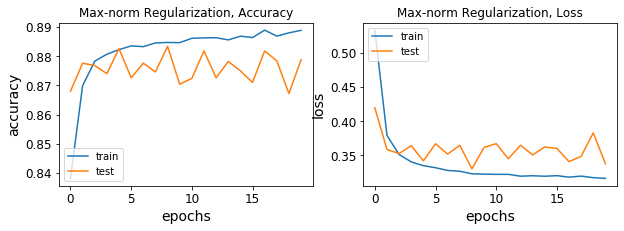

In [ ]:
plot_accuracy_and_loss(history, 'Max-norm Regularization')

The max_norm() function has an axis argument that defaults to 0. A Dense layer usually
has weights of shape [number of inputs, number of neurons], so using axis=0
means that the max norm constraint will apply independently to each neuron’s weight
vector. If you want to use max-norm with convolutional layers make sure to set the max_norm() constraint’s axis argument appropriately (usually
axis=[0, 1, 2]).